#### imports

In [1]:
from sympy import solve
import random
import itertools
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from sympy import *
from IPython.display import display, Math
import numpy as np
init_printing(use_unicode=True)
pd.set_option('display.max_rows', 500)
random.seed(500)
from numba import njit

H = 0.01 * 5


x, y, sigma, mu, delta, alpha, beta, ro, eta, b, lambd = symbols(
    'x y σ μ δ α β ρ η b λ')

sigma_c = 0.1181
ro_c = 1.131
eta_c = 20.19
alpha_c = 1.636
beta_c = 0.002
delta_c = 0.3743
mu_c = 0.005
b_c = 0

dxdt = sigma + ro*x*y/(eta + y) - mu*x*y - delta*x
dydt = alpha*y*(1-beta*y)-x*y-(b*y)/(1+y)

concrete_params = {ro: ro_c, sigma: sigma_c, eta: eta_c, b: b_c,
                   alpha: alpha_c, beta: beta_c, mu: mu_c, delta: delta_c}
muless_params = dict(concrete_params)
del muless_params[mu]

bless_params = dict(concrete_params)
del bless_params[b]

mu_c = 0.014
bless_params[mu] = mu_c

display(Math('\dfrac{dx}{dt} = ' + latex(dxdt)))
display(Math('\dfrac{dy}{dt} = ' + latex(dydt)))

from typing import Tuple


def get_solutions(params):
    return solve([dxdt.subs(params), dydt.subs(params)], x, y)


def display_solutions(sols):
    for s in sols:
        display(s)


def display_sol_list(sol_list):
    for cur_mu, sols in sol_list:
        print(f"mu = {cur_mu}")
        display_solutions(sols)
        display("*"*20)


def sol_is_almost_real(sol):
    x, y = sol
    return abs(im(x)) < 1e-10 and abs(im(y)) < 1e-10


def cast_to_real(sol):
    x, y = sol
    return float(re(x)), float(re(y))


def get_eigen_values(x_eq, y_eq, params):
    a11 = dfdx.evalf(subs=params | {x: x_eq, y: y_eq})
    a12 = dfdy.evalf(subs=params | {x: x_eq, y: y_eq})
    a21 = dgdx.evalf(subs=params | {x: x_eq, y: y_eq})
    a22 = dgdy.evalf(subs=params | {x: x_eq, y: y_eq})
    jacob_matrix = Matrix([[a11, a12], [a21, a22]])
    j = jacob_matrix - np.eye(2) * lambd
    lam1, lam2 = solve(j.det(), lambd)
    return lam1, lam2


dfdx = diff(dxdt, x)
dfdy = diff(dxdt, y)
dgdx = diff(dydt, x)
dgdy = diff(dydt, y)

# display(Math('\dfrac{df}{dx} = ' + latex(dfdx)))
# display(Math('\dfrac{df}{dy} = ' + latex(dfdy)))
# display(Math('\dfrac{dg}{dx} = ' + latex(dgdx)))
# display(Math('\dfrac{dg}{dy} = ' + latex(dfdy)))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

##### computing & plotting fucntions


In [33]:
from plotly.io import from_json, to_json
from collections import defaultdict
from functools import partial
from functools import lru_cache
import json
import math


def get_line_mode(stable):
    return {} if stable else {"dash": "dot"}


def get_positive_prefix_mask(ts):
    negative = ts[ts < 0]
    if negative.empty:
        return ts.index
    i = negative.index[0]
    return ts[ts.index < i].index


def get_n_solutions_by_bxy(params, starts):
    res = set()
    for x_start, y_start in (pbar := tqdm(starts)):
        pbar.set_description(f"Finding eq")
        try:
            res.add(ImmutableMatrix(
                nsolve([dxdt.subs(params), dydt.subs(params)], (x, y), (x_start, y_start))))
        # Could not find root within given tolerance. (1.56236416469305495856 > 2.16840434497100886801e-19)
        except ValueError:
            # Try another starting point or tweak arguments.
            pass
    return res


def f(x_c, y_c, params, reverse=False):  # dx/dt
    return (-1 if reverse else 1) * dxdt.evalf(subs=(params | {x: x_c, y: y_c}))


def g(x_c, y_c, params, reverse=False):  # dy/dt
    return (-1 if reverse else 1) * dydt.evalf(subs=(params | {x: x_c, y: y_c}))

# runge-kutta

# @njit


def get_next(x, y, h, params, reverse=False):
    k1 = h * f(x, y, params, reverse=reverse)
    l1 = h * g(x, y, params, reverse=reverse)
    k2 = h * f(x + k1 / 2, y + l1 / 2, params, reverse=reverse)
    l2 = h * g(x + k1 / 2, y + l1 / 2,  params, reverse=reverse)
    k3 = h * f(x + k2 / 2, y + l2 / 2,  params, reverse=reverse)
    l3 = h * g(x + k2 / 2, y + l2 / 2,  params, reverse=reverse)
    k4 = h * f(x + k3, y + l3, params, reverse=reverse)
    l4 = h * g(x + k3, y + l3,  params, reverse=reverse)
    return (x + (k1 + 2 * k2 + 2 * k3 + k4) / 6,
            y + (l1 + 2 * l2 + 2 * l3 + l4) / 6)


# add_first_cut ==True - нужно в путь добавить то значение,
# из-за которого не стали продолжать считать путь (ушли в отрицательные)
get_next_deterministic = get_next
# @njit


def _get_path(start_no, num_steps, x_c, y_c, params, reverse, h, add_first_cut):
    path = pd.DataFrame(columns=['no', 'step', 'x', 'y', 'path_id'])
    path_id = random.randint(0, 10**6)
    for step in range(num_steps):
        path.loc[len(path)] = [start_no, step, x_c, y_c, path_id]
        x_c, y_c = get_next(x_c, y_c, h, params, reverse)
        if x_c < -1e3 or y_c < -1e3:
            print(f"Reached negative values at step {step}: {x_c, y_c}")
            if add_first_cut:
                path.loc[len(path)] = [start_no, step+1, x_c, y_c, path_id]
            return path
        if abs(x_c) > 1e10 or abs(y_c) > 1e10:
            print(f"Reached too large value at path no {start_no}")
            return path
        if sol_is_almost_real((x_c, y_c)):
            x_c, y_c = cast_to_real((x_c, y_c))
        else:
            raise ValueError(f"Solution is essentially complex {x_c, y_c}")
    return path


_get_path_const_h = _get_path

# @njit


def _get_path_variable_h(start_no, num_steps, x_c, y_c, params, reverse, h, add_first_cut):
    path = pd.DataFrame(columns=['no', 'step', 'x', 'y', 'path_id', 'h'])
    path_id = random.randint(0, 10**6)
    curh = h
    for step in range(num_steps):
        path.loc[len(path)] = [start_no, step, x_c, y_c, path_id, curh]
        prev_y = y_c
        x_c, y_c = get_next(x_c, y_c, curh, params, reverse)
        if abs(y_c**(1/4) - prev_y**(1/4)) > 0.1:
            curh = curh / 2
        if x_c < -1e3 or y_c < -1e3:
            print(f"Reached negative values at step {step}: {x_c, y_c}")
            if add_first_cut:
                path.loc[len(path)] = [start_no, step +
                                       1, x_c, y_c, path_id, curh]
            return path
        if abs(x_c) > 1e10 or abs(y_c) > 1e10:
            print(f"Reached too large value at path no {start_no}")
            return path
        if sol_is_almost_real((x_c, y_c)):
            x_c, y_c = cast_to_real((x_c, y_c))
        else:
            raise ValueError(f"Solution is essentially complex {x_c, y_c}")
    return path

# @njit


def get_paths(params, starts, num_steps, h=H, reverse=False, spec_name=None,
              add_first_cut=False):
    paths = []
    # for start_no, (x_c, y_c) in list(enumerate(starts)):
    for start_no, (x_c, y_c) in (pbar := tqdm(list(enumerate(starts)))):
        pbar.set_description(f"Finding paths")
        path = _get_path(start_no, num_steps, x_c, y_c,
                         params, reverse, h, add_first_cut).astype(float)
        if spec_name:
            path["name"] = spec_name
        else:
            calculated_name = 'to_zt' if (
                abs(path.y.iloc[-1] - 0) < 1e-6) else 'to_at'
            path["name"] = calculated_name
        paths.append(path)
    paths = pd.concat(paths).reset_index(drop=True)
    paths["ysqrt4"] = np.power(paths.y, 1/4)
    return paths


def union_same_solutions(solutions):
    return list(set((round(x, 5), round(y, 5))for x, y in solutions))


def get_white_fig():
    fig = go.Figure()
    fig.update_layout(template="plotly_white",
                      width=600,
                      height=500)
    return fig


def get_fig(params):
    fig = go.Figure()
    fig.update_layout(
        title=f"Phase portrait. 𝜇 = {params[mu]} b = {params[b]}")
    fig.update_layout(xaxis={"title": "x"}, yaxis={
                      "title": r'$y^{1/4}$'}, template="plotly_white",
                      width=600,
                      height=500)
    return fig


def get_fig_ts(params):
    fig = go.Figure()
    fig.update_layout(
        title=f"Time series. 𝜇 = {params[mu]} b = {params[b]}")
    fig.update_layout(xaxis={"title": "t"}, yaxis={
                      "title": r'$y^{1/4}$'}, template="plotly_white",
                      width=600,
                      height=500)
    return fig


def fig_add_paths(fig, paths, auto_define_color=True, name=""):
    fig = go.Figure(fig)
    for (path_id, where_to, path_no), path in paths.groupby(
            ["path_id", "name", "no"]):
        line_style = {}
        # зеленая, если у пришел в 0. (ZT)
        scatter_params = dict(x=path.x, y=path.ysqrt4, customdata=path.step,
                              mode='lines', name=name,
                              hovertemplate='<br>'.join([
                                  'x: %{x}',
                                  'y: %{y}',
                                  'step_no: %{customdata}',
                              ])
                              )
        if auto_define_color:
            traj_color = 'green' if abs(path.y.iloc[-1] - 0) < 1e-6 else 'red'
            scatter_params['line'] = dict(
                color=traj_color,
                width=1.5)
        fig.add_trace(go.Scatter(scatter_params))
    return fig


def fig_add_ts(fig, paths):
    for (path_id, name, path_no), path in paths[paths.name != 'sep'].groupby(
            ["path_id", "name", "no"]):
        fig.add_trace(go.Scatter(x=path.h.cumsum(), y=path.ysqrt4,
                                 name=f'{name}, id = {path_id}, no={path_no}'))
    return fig


def fig_add_ellipse(fig, ellipse, name):
    fig = go.Figure(fig)
    fig.add_trace(go.Scatter(x=ellipse.x, y=ellipse.ysqrt4,
                  mode="markers", name=name))
    return fig


def get_fig_phase_portrait(paths, params):
    fig = go.Figure()
    for (path_id, name, path_no), path in paths[paths.name != 'sep'].groupby(
            ["path_id", "name", "no"]):
        # зеленая, если у пришел в 0. (ZT)
        traj_color = 'green' if abs(path.y.iloc[-1] - 0) < 1e-6 else 'red'
        fig.add_trace(go.Scatter(x=path.x, y=path.ysqrt4, customdata=path.step,
                                 mode='lines', name="",
                                 hovertemplate='<br>'.join([
                                     'x: %{x}',
                                     'y: %{y}',
                                     'step_no: %{customdata}',
                                 ]),
                                 line=dict(
                                     color=traj_color,
                                     width=1.5)))
    fig.update_layout(
        title=f"Phase portrait. 𝜇 = {params[mu]} b = {params[b]}")
    fig.update_layout(xaxis={"title": "x"}, yaxis={
                      "title": r'$y^{1/4}$'}, template="plotly_white",
                      width=600,
                      height=500)
    return fig


def get_eqs(params):
    starts = (list(itertools.product(np.linspace(0, 1, 10), np.linspace(256, 1400, 10))) +
              list(itertools.product(np.linspace(0, 1, 10), np.linspace(0, 0.1**4, 10))))

    solutions = get_n_solutions_by_bxy(params, starts)
    solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]
    return solutions


def get_eqs_by_starts(params, starts):
    solutions = get_n_solutions_by_bxy(params, starts)
    solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]
    return solutions


def compute_phase_portrait(b_const, paths_starts, num_steps=1000, h=H):
    params = bless_params | {b: b_const}
    paths = get_paths(params, paths_starts, num_steps, h)
    return get_fig_phase_portrait(paths, params), paths


def get_separatrix_paths(params, separatrix_starts, num_steps=1000, h=H):
    global get_next
    global _get_path
    saved = get_next
    saved_get_p = _get_path
    _get_path = _get_path_const_h
    get_next = get_next_deterministic
    separatrix_paths = get_paths(
        params, separatrix_starts, num_steps, h, reverse=True)
    separatrix_paths = separatrix_paths[(
        separatrix_paths.x < 4.2) & (separatrix_paths.x > 0)]
    separatrix_paths["name"] = "sep"
    get_next = saved
    _get_path = saved_get_p
    return separatrix_paths


def add_separatrix(fig, separatrix_paths):
    for path_no, path in separatrix_paths.groupby("no"):
        fig.add_trace(go.Scatter(x=path.x, y=path.ysqrt4, mode='lines', name="",
                                 line=dict(
                                     color='red',
                                     width=1.5,
                                     dash="dot")))
    return fig


def plot_eq(eq, fig, color, name):
    x = [eq[0]]
    y = [eq[1]**(1/4)]
    if color in ('red', 'green'):
        fig.add_trace(go.Scatter(x=x, y=y, name=name, line=dict(color=color)))
    elif color == 'white':
        fig.add_trace(go.Scatter(x=x, y=y, name=name,
                                 marker=dict(color='white',
                                             line=dict(color='black', width=1))))
    else:
        raise ValueError(f"unknown color {color}")


def get_norm_random():  # ~N(0,1)
    a = random.random()
    b = random.random()
    return ((-2*math.log(a))**0.5*math.cos(2*math.pi*b),
            (-2*math.log(a))**0.5*math.sin(2*math.pi*b))


def get_next_noisy(x, y, h, params, reverse=False, eps=1):
    ksi, eta = get_norm_random()
    ksi = ksi * math.sqrt(h)  # ~N(0,h). Это приращение Винеровского процесса
    eta = eta * math.sqrt(h)
    b_determined = params[b]
    if eps*eta < -b_determined:
        eta = -b_determined/eps

    noisy_b = b_determined + eps*eta
    if noisy_b < 0:
        raise Exception(noisy_b, b_determined, eta)
    # b_distr.add(noisy_b)
    phi = -y / (1+y)
    # noisy_b = params[b]+(3000 * eps * random.uniform(-1, 1))
    # b_distr.add(noisy_b)
    cur_params = dict(params)
    # cur_params[b] = noisy_b
    k1 = h * f(x, y, cur_params, reverse=reverse)
    l1 = h * g(x, y, cur_params, reverse=reverse)
    k2 = h * f(x + k1 / 2, y + l1 / 2, cur_params, reverse=reverse)
    l2 = h * g(x + k1 / 2, y + l1 / 2,  cur_params, reverse=reverse)
    k3 = h * f(x + k2 / 2, y + l2 / 2,  cur_params, reverse=reverse)
    l3 = h * g(x + k2 / 2, y + l2 / 2,  cur_params, reverse=reverse)
    k4 = h * f(x + k3, y + l3, cur_params, reverse=reverse)
    l4 = h * g(x + k3, y + l3,  cur_params, reverse=reverse)
    return (x + ((k1 + 2 * k2 + 2 * k3 + k4) / 6),
            y + ((l1 + 2 * l2 + 2 * l3 + l4) / 6) + eps * phi * eta)


def plot_eqs(fig, eq_at, eq_zt, eq_sep):
    plot_eq(eq_at, fig, 'red', 'eq AT')
    plot_eq(eq_zt, fig, 'green', 'eq ZT')
    plot_eq(eq_sep, fig, 'white', 'eq sep')


def get_jacobi_matrix():
    f11, f12, f21, f22 = symbols('f11 f12 f21 f22')
    F = Matrix([[f11, f12], [f21, f22]]).evalf(
        subs={f11: dfdx, f12: dfdy,
              f21: dgdx, f22: dgdy})
    return F


def get_ssm_phys(eq, params):
    x_eq, y_eq = eq
    s2 = y/(4*(1+y**4))
    S = Matrix([[0, 0], [0, s2**2]]).evalf(subs={y: y_eq})
    # sigma_mat = Matrix([[0, 0], [0,]])#TODO для моей системы иначе
    F = get_jacobi_matrix().evalf(subs=params | {x: x_eq, y: y_eq}
                                  )  # производные по аргументам

    w11, w12, w21, w22 = symbols('w11 w12 w21 w22')
    W = Matrix([[w11, w12], [w21, w22]])
    gen_sol = solve(F*W + W*F.T + S, W)
    return Matrix([[gen_sol[w11], gen_sol[w12]],
                   [gen_sol[w21], gen_sol[w22]]])
    W_f = W_solved_general.evalf(subs={f11: dfdx, f12: dfdy,
                                       f21: dgdx, f22: dgdy}
                                 | params
                                 | {x: x_eq, y: y_eq,
                                    }
                                 )
    return W_f


def get_ssm(eq, params):
    x_eq, y_eq = eq
    # TODO для моей системы иначе
    sigma_mat = Matrix([[0, 0], [0, y/(4*(1+y**4))]])
    f11, f12, f21, f22 = symbols('f11 f12 f21 f22')
    F = Matrix([[f11, f12], [f21, f22]])  # производные по аргументам

    w11, w12, w21, w22 = symbols('w11 w12 w21 w22')
    W = Matrix([[w11, w12], [w21, w22]])
    xeq, yeq = symbols(r"\bar{x} \bar{y}")
    G = sigma_mat * Matrix([xeq, yeq])
    S = G * G.T
    gen_sol = solve(F*W + W*F.T + S, W)
    W_solved_general = Matrix([[gen_sol[w11], gen_sol[w12]],
                               [gen_sol[w21], gen_sol[w22]]])
    W_f = W_solved_general.evalf(subs={f11: dfdx, f12: dfdy,
                                       f21: dgdx, f22: dgdy}
                                 | params
                                 | {x: x_eq, y: y_eq,
                                    xeq: x_eq, yeq: y_eq}
                                 )
    return W_f


def get_ellipse(eq, fid_prob, eps, params):
    W_f = get_ssm(eq, params)
    eig_val1, eig_val2 = [e_val for (e_val, m, _) in W_f.eigenvects()]
    v1, v2 = [vecs[0].normalized() for (e_val, m, vecs) in W_f.eigenvects()]
    z1 = (Matrix([x, y]) - Matrix(eq)).dot(v1)
    z2 = (Matrix([x, y]) - Matrix(eq)).dot(v2)
    # k_sq = (-math.log(1-fid_prob))**2  # NOTE TODO без **2 в магистерской
    # но в PhysRev что-то похожее с квадратом
    ellipse_general_form = solve(
        # (z1**2)/eig_val1 + (z2**2)/eig_val2 - 2*k_sq*eps**2, y
        (z1**2)/eig_val1 + (z2**2)/eig_val2 + 2*(eps**2)*math.log(1-fid_prob), y
    )
    ellipse = set()
    for curx in np.concatenate([
        # np.linspace(-100, 100, 10000),
        np.linspace(1.2, 1.8, 100),  # TODO у меня по-другому
    ]):
        for semi_func in ellipse_general_form:
            sol = curx, semi_func.evalf(subs={x: curx})
            if sol_is_almost_real(sol):
                sol = cast_to_real(sol)
                ellipse.add(sol)

    ellipse = pd.DataFrame(ellipse, columns=['x', 'y'])
    ellipse["ysqrt4"] = np.power(ellipse.y, 1/4)
    ellipse = ellipse.astype(float)
    return ellipse


def get_united_constraint_eqs(params):
    """ Returns equilibrium points.
    Almost same points are united.
    Restriction of positiveness on x and y is applied
    """
    eqs = get_eqs(params)
    united_eqs = sorted(union_same_solutions(eqs))
    return [(eqx, eqy) for (eqx, eqy) in united_eqs if eqx >= 0 and eqy >= 0]


def get_positive_prefix(path):
    path = path.loc[get_positive_prefix_mask(path.x)]
    path = path.loc[get_positive_prefix_mask(path.y)]
    if path.empty:
        print('Contrained path is empty')
    return path


def cut_positive_prefixes(paths):
    r = []
    for _, path in paths.groupby('path_id'):
        r.append(get_positive_prefix(path))
    return pd.concat(r).reset_index(drop=True)


def get_paths_constrained(params, starts, num_steps, h=H):
    paths = get_paths(params, starts, num_steps=num_steps, h=h)
    return cut_positive_prefixes(paths)


def get_probs(noisy_paths):
    out = defaultdict(int)
    total = defaultdict(int)
    for (cur_eps, curb), paths in noisy_paths.groupby(["eps", "b"]):
        total[(curb, cur_eps)] = paths.path_id.nunique()
        for _, path in paths.groupby("path_id"):
            out[(curb, cur_eps)] += int(path.y.min() < 1.5**4)

    r = []
    for (curb, cur_eps), total_cnt in total.items():
        r.append((curb, cur_eps, out[(curb, cur_eps)], total_cnt))
    df = pd.DataFrame(r, columns=['b', 'eps', 'out', 'total'])
    df['p'] = df.out/df.total
    return df


def fig_dump(fig, name):
    with open(f'fig_jsons/{name}.json', 'w') as f:
        json.dump(to_json(fig), f)


def fig_load(name):
    with open(f'fig_jsons/{name}.json') as f:
        return from_json(json.load(f))


In [3]:
# mus = np.linspace(0.002, 0.022, 50)

mus = np.concatenate([
    np.linspace(0.0020, 0.0026, 50, endpoint=False),
    np.linspace(0.0026, 0.00265, 50, endpoint=False),
    np.linspace(0.00265, 0.0040, 50, endpoint=False),
    np.linspace(0.0040, 0.0130, 50, endpoint=False),
    np.linspace(0.0131, 0.0133, 50, endpoint=False),
    np.linspace(0.0130, 0.0135, 50, endpoint=False),
    np.linspace(0.0135, 0.0220, 50, endpoint=False)
])


In [ ]:
xs = []
ys = []
mul = []
solutions_by_mu = {}
for cur_mu in tqdm(mus):
    solutions = get_solutions(muless_params | {mu: cur_mu})
    solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]
    solutions_by_mu[cur_mu] = solutions


In [ ]:
# y_im_parts = []
# x_im_parts = []
# mus_for_im=[]
# for cur_mu, sols in list(solutions_by_mu.items()):
#     for cur_x,cur_y in sols:
#         x_im_parts.append(float(cur_x))
#         y_im_parts.append(float(cur_y))
#         mus_for_im.append(cur_mu)

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=mus_for_im, y=x_im_parts, mode='markers', name = "x_im_parts"))
# fig.add_trace(go.Scatter(x=mus_for_im, y=y_im_parts, mode='markers', name = "y_im_parts"))
# fig.update_layout(title="Imaginary parts of X and Y")
# fig.update_layout(xaxis={"title": "mu"})


In [ ]:
mu_min = 0.002
mu_max = 0.017
filtered_solutions_by_mu = {
    mu: solutions_by_mu[mu] for mu in solutions_by_mu if mu_min < mu < mu_max}
# filtered_solutions_by_mu


In [ ]:
# display_sol_list(list(filtered_solutions_by_mu.items())[:2])


In [ ]:
xs = []
ys = []
mus_bif = []
df = pd.DataFrame(columns=['mu', 'x', 'y', 'stable'])
for cur_mu, sols in tqdm(list(filtered_solutions_by_mu.items())):
    for cur_x, cur_y in sols:
        lam1, lam2 = get_eigen_values(float(cur_x), float(
            cur_y), muless_params | {mu: cur_mu})
        stable = re(lam1) < 0 and re(lam2) < 0
        df.loc[len(df)] = [cur_mu, float(cur_x), float(cur_y), stable]


df.stable = df.stable.astype(bool)
df = df[df.y != 0]


# fig.add_trace(go.Scatter(x=stables.mu, y=stables.y, mode='markers', name = "y"))


In [ ]:
df.y = df.y.astype('float')
df.stable = df.stable.astype(bool)

df.sort_values('y', inplace=True)
stables = df[df.stable]
dormants = df[df.stable & (df.y < 200)]
actives = df[df.stable & (df.y > 200)]
unstables = df[~df.stable]


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=actives.mu, y=actives.y, mode='lines', name="actives",
                         line={"color": "red"} | get_line_mode(stable=True)))

fig.add_trace(go.Scatter(x=dormants.mu, y=dormants.y, mode='lines', name="dormants",
                         line={"color": "blue"} | get_line_mode(stable=True)))

fig.add_trace(go.Scatter(x=unstables.mu, y=unstables.y, mode='lines', name="unstable",
                         line={"color": "black"} | get_line_mode(stable=False)))
# fig.add_trace(go.Scatter(x=df.mu, y=df.y, mode='markers', name = "y"))
fig.update_layout(title="Fig 1. Bifurcation diagram with no treatment. b = 0")
fig.update_layout(xaxis={"title": "μ"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
                  width=600,
                  height=500)
fig.update_yaxes(type="log")
# fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)


## 𝜇 = 0.014. Monostable active. b is variable

In [ ]:
mu_c = 0.014
bless_params[mu] = mu_c


In [ ]:
def get_n_solutions_by_b(params, y_starts):
    res = set()
    for y_start in y_starts:
        try:
            res.add(ImmutableMatrix(
                nsolve([dxdt.subs(params), dydt.subs(params)], (x, y), (0, y_start))))
        # Could not find root within given tolerance. (1.56236416469305495856 > 2.16840434497100886801e-19)
        except ValueError:
            # Try another starting point or tweak arguments.
            pass
    return res


In [ ]:
solutions_by_b = {}
bs_full_range = np.concatenate([
    np.linspace(0.0, 200, 500, endpoint=False),
    np.linspace(194, 195, 50, endpoint=False),
    np.linspace(10, 25, 100, endpoint=False),
])
bs_smalls = np.concatenate([
    np.linspace(0.0, 10, 100, endpoint=False),
    np.linspace(8.2, 8.4, 100, endpoint=False),
    np.linspace(8.334, 8.336, 10, endpoint=False)
])
for bs_set, y_starts in zip([bs_full_range, bs_smalls],
                            [np.linspace(0, 600, 6), np.linspace(0, 30, 6)]):
    for curb in tqdm(bs_set):
        solutions = get_n_solutions_by_b(bless_params | {b: curb}, y_starts)
        solutions = [cast_to_real(s)
                     for s in solutions if sol_is_almost_real(s)]
        solutions_by_b[curb] = solutions


In [ ]:
bif_solutions_by_b = dict(solutions_by_b)


In [ ]:
df = pd.DataFrame({'b': pd.Series(dtype='float'),
                   'x': pd.Series(dtype='float'),
                   'y': pd.Series(dtype='float'),
                   'stable': pd.Series(dtype='bool')})
for curb, sols in tqdm(solutions_by_b.items()):
    for sol in sols:
        cur_x, cur_y = sol
        lam1, lam2 = get_eigen_values(
            float(cur_x), float(cur_y), bless_params | {b: curb})
        stable = re(lam1) < 0 and re(lam2) < 0
        df.loc[len(df)] = [curb, float(cur_x), float(cur_y), stable]

df.stable = df.stable.astype(bool)
orig = df.copy()


In [ ]:
df.b = df.b.astype(float)


In [ ]:
# df = df[(df.y>=0) & (df.y.abs()>1e-10)]
df = df[(df.y >= 0)]
df.sort_values('y', inplace=True)


### ! Bifurcation diagram. 𝜇 = 0.014

In [ ]:
fig = go.Figure()
stables = df[df.stable & (df.y != 0)]
unstables = df[~df.stable & (df.y != 0)]
zero_tumor_stables = df[df.stable & (df.y == 0)]
zero_tumor_unstables = df[~df.stable & (df.y == 0)]

fig.add_trace(go.Scatter(x=stables.b, y=stables.y, mode='lines', name="stables",
              line={"color": "red"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=unstables.b, y=unstables.y, mode='lines', name="unstables",
                         line={"color": "red"} | get_line_mode(stable=False)))
fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines', name="zero_tumor_stables",
                         line={"color": "green"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines', name="zero_tumor_unstables",
                         line={"color": "green"} | get_line_mode(stable=False)))

fig.update_layout(title="Fig 2(c). Bifurcation diagram. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
                  width=700,
                  height=500)


In [ ]:
# fig = go.Figure()
# stables = df[df.stable & (df.y != 0)]
# unstables = df[~df.stable & (df.y != 0)]
# zero_tumor_stables = df[df.stable & (df.y == 0)]
# zero_tumor_unstables = df[~df.stable & (df.y == 0)]

# fig.add_trace(go.Scatter(x=stables.b, y=stables.y, mode='lines+markers', name="stables",
#               line={"color": "red"} | get_line_mode(stable=True)))
# fig.add_trace(go.Scatter(x=unstables.b, y=unstables.y, mode='lines+markers', name="unstables",
#                          line={"color": "red"} | get_line_mode(stable=False)))
# fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines+markers', name="zero_tumor_stables",
#                          line={"color": "green"} | get_line_mode(stable=True)))
# fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines+markers', name="zero_tumor_unstables",
#                          line={"color": "green"} | get_line_mode(stable=False)))

# fig.update_layout(title="Fig 2(c). Bifurcation diagram. 𝜇 = 0.014")
# fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
#                   width=700,
#                   height=500)


In [ ]:
# Note: b в районе 10 - 20 - решения не находятся


In [ ]:
dfsmall = df[df.b.isin(bs_smalls)]


In [ ]:
b1 = 5.8
b2 = 8.3356


In [ ]:
lower_flexure = dfsmall[(dfsmall.y > 5) & (dfsmall.y < 17)]
upper_flexure = dfsmall[(dfsmall.y > 17) & (dfsmall.y < 24)]
b2_exp = lower_flexure.b.max()
b1_exp = upper_flexure.b.min()
lower_flexure_y = dfsmall[(dfsmall.b == b2_exp) & (
    dfsmall.y < 10.5) & (dfsmall.y > 9)]
b1_exp, b2_exp


In [ ]:
y_low_thrsh = lower_flexure_y.y.mean()
y_low_thrsh


In [ ]:
pink = dfsmall[(dfsmall.b <= b2) & (dfsmall.y <= y_low_thrsh)
               & ~dfsmall.stable & (dfsmall.y > 0)]
blue = dfsmall[(dfsmall.b >= b1) & (dfsmall.b <= b2) & (
    y_low_thrsh < dfsmall.y) & (dfsmall.y < 19) & ~dfsmall.stable]
red = dfsmall[(dfsmall.b > b1) & (dfsmall.y > 18.8) & ~dfsmall.stable]

zero_tumor_stables = dfsmall[dfsmall.stable & (dfsmall.y == 0)]
zero_tumor_unstables = dfsmall[~dfsmall.stable & (dfsmall.y == 0)]


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=pink.b, y=pink.y, mode='lines', name="",
              line={"color": "magenta"} | get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=blue.b, y=blue.y, mode='lines', name="",
              line={"color": "blue"} | get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=red.b, y=red.y, mode='lines', name="",
              line={"color": "red"} | get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines', name="zero_tumor_stables",
                         line={"color": "green"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines', name="zero_tumor_unstables",
                         line={"color": "green"} | get_line_mode(stable=False)))

fig.update_layout(title="Fig 2(c)(b < 15). Bifurcation diagram. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
                  width=700,
                  height=500)


In [ ]:
# for bs_set, y_starts in zip([bs_full_range, bs_smalls],
#                             [np.linspace(0, 600, 6), np.linspace(0, 30, 6)]):


In [ ]:
mu_c = 0.014
bless_params[mu] = mu_c


## Атлас

In [ ]:
paths_by_b = {}


#### b_const = 1

In [ ]:
b_const = 1
H = 0.05
y_starts = np.concatenate([
    np.linspace(0.1, 1400, 6),
    [3.4**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
starts = list(itertools.product([4], y_starts))

fig, paths = compute_phase_portrait(b_const, paths_starts=starts)
united_eqs = sorted(union_same_solutions(eqs))

eq_at, eq_zt = united_eqs

zt_paths = get_paths(bless_params | {b: b_c},
                     starts=[(4, 0), (0.00001, 0)], num_steps=1000, name='zt')

paths = pd.concat([paths, zt_paths])
fig.add_trace(go.Scatter(x=zt_paths.x, y=zt_paths.ysqrt4, mode='lines', name="",
                         line=dict(
                             color='black',
                             width=1.5)))

fig.add_trace(go.Scatter(x=[eq_at[0]], y=[
              eq_at[1]**(1/4)], name='eq AT', line=dict(color='red')))
fig.add_trace(go.Scatter(x=[eq_zt[0]], y=[eq_zt[1]**(1/4)], name='eq ZT',
                         marker=dict(color='white',
                                     line=dict(color='black', width=1))))
paths_by_b[b_const] = paths
paths_by_b[b_const].to_csv(f"paths/{b_const}.csv")

fig.show()


#### b_const = 10

In [ ]:
b_const = 10
H = 0.05

y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
# print(united_eqs)
eq_at, eq_zt, eq_sep = united_eqs

starts = (list(itertools.product([4], y_paths_starts))
          + [
              (0.1, 1.6**4),
    (0.1, 1.5**4),
    (eq_sep[0], eq_sep[1]-0.001)]
)
fig, paths = compute_phase_portrait(b_const, paths_starts=starts)


separatrix_starts = [(1.2, 2.3**4), (1.15, 2.2**4)]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts)

paths = pd.concat([paths, separatrix_paths])
fig = add_separatrix(fig, separatrix_paths)

plot_eq(eq_at, fig, 'red', 'eq AT')
plot_eq(eq_zt, fig, 'green', 'eq ZT')
plot_eq(eq_sep, fig, 'white', 'eq sep')

paths_by_b[b_const] = paths
paths_by_b[b_const].to_csv(f"paths/{b_const}.csv")

fig.show()


#### b_const = 15

In [ ]:
b_const = 15
H = 0.05

y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
# print(united_eqs)
eq_at, eq_zt, eq_sep = united_eqs

starts = (list(itertools.product([4], y_paths_starts))
          + [
              (0.1, 1.6**4),
    (0.1, 1.5**4),
    (eq_sep[0], eq_sep[1]-0.001)]
)
fig, paths = compute_phase_portrait(b_const, paths_starts=starts)


separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts)

paths = pd.concat([paths, separatrix_paths])

fig = add_separatrix(fig, separatrix_paths)

plot_eq(eq_at, fig, 'red', 'eq AT')
plot_eq(eq_zt, fig, 'green', 'eq ZT')
plot_eq(eq_sep, fig, 'white', 'eq sep')

paths_by_b[b_const] = paths

paths_by_b[b_const].to_csv(f"paths/{b_const}.csv")

fig.show()


#### b_const = 30

In [ ]:
b_const = 30
H = 0.05

y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
# print(united_eqs)
eq_at, eq_zt, eq_sep = united_eqs

starts = (list(itertools.product([4], y_paths_starts))
          + [
              (0.1, 1.6**4),
    (0.1, 1.5**4),
    (eq_sep[0], eq_sep[1]-0.001)]
)
fig, paths = compute_phase_portrait(b_const, paths_starts=starts)


separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts)

paths = pd.concat([paths, separatrix_paths])

fig = add_separatrix(fig, separatrix_paths)

plot_eq(eq_at, fig, 'red', 'eq AT')
plot_eq(eq_zt, fig, 'green', 'eq ZT')
plot_eq(eq_sep, fig, 'white', 'eq sep')

paths_by_b[b_const] = paths

paths_by_b[b_const].to_csv(f"paths/{b_const}.csv")

fig.show()


#### b_const = 50

In [ ]:
b_const = 50

H = 0.01
y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
# print(united_eqs)
eq_at, eq_zt, eq_sep = united_eqs

starts = (list(itertools.product([4], y_paths_starts))
          + [
              (0.1, 1.6**4),
    (0.1, 1.5**4),
    (1, 2.5**4),
    (2, 3**4),
    (eq_sep[0], eq_sep[1]-0.001)]
)
fig, paths = compute_phase_portrait(
    b_const, paths_starts=starts, num_steps=2000)


separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts, num_steps=1000, h=0.05)

paths = pd.concat([paths, separatrix_paths])

fig = add_separatrix(fig, separatrix_paths)

plot_eq(eq_at, fig, 'red', 'eq AT')
plot_eq(eq_zt, fig, 'green', 'eq ZT')
plot_eq(eq_sep, fig, 'white', 'eq sep')


paths_by_b[b_const] = paths
paths_by_b[b_const].to_csv(f"paths/{b_const}.csv")

fig.show()


#### b_const = 100

In [ ]:
b_const = 100

H = 0.01
y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
# print(united_eqs)
# TODO: надо определять по собственным числам, кто устойчив, а кто - нет
eq_at, eq_sep, eq_zt = united_eqs

starts = (list(itertools.product([4], y_paths_starts))
          + [
              (0.1, 1.6**4),
    (0.1, 1.5**4),
    (1, 2.5**4),
    (2, 3**4),
    (eq_sep[0], eq_sep[1]-0.001)]
)
fig, paths = compute_phase_portrait(b_const, paths_starts=starts, num_steps=2000,
                                    h=0.01)


separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts, num_steps=1000, h=0.05)
paths = pd.concat([paths, separatrix_paths])


fig = add_separatrix(fig, separatrix_paths)

plot_eq(eq_at, fig, 'red', 'eq AT')
plot_eq(eq_zt, fig, 'green', 'eq ZT')
plot_eq(eq_sep, fig, 'white', 'eq sep')


paths_by_b[b_const] = paths
paths_by_b[b_const].to_csv(f"paths/{b_const}.csv")

fig.show()


In [ ]:
b_const = 150

H = 0.01
y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
# print(united_eqs)
# TODO: надо определять по собственным числам, кто устойчив, а кто - нет
eq_at, eq_sep, eq_zt = united_eqs

starts = (list(itertools.product([4], y_paths_starts))
          + [
              (0.1, 1.6**4),
    (0.1, 1.5**4),
    (1, 2.5**4),
    (2, 3**4),
    (eq_sep[0], eq_sep[1]-0.001)]
)
fig, paths = compute_phase_portrait(b_const, paths_starts=starts, num_steps=2000,
                                    h=0.01)


separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts, num_steps=1000, h=0.05)
paths = pd.concat([paths, separatrix_paths])


fig = add_separatrix(fig, separatrix_paths)

plot_eq(eq_at, fig, 'red', 'eq AT')
plot_eq(eq_zt, fig, 'green', 'eq ZT')
plot_eq(eq_sep, fig, 'white', 'eq sep')


paths_by_b[b_const] = paths
paths_by_b[b_const].to_csv(f"paths/{b_const}.csv")

fig.show()


#### b_const = 120

In [ ]:
b_const = 120

H = 0.01
y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
# print(united_eqs)
eq_at, eq_sep, eq_zt = united_eqs

starts = (list(itertools.product([4], y_paths_starts))
          + [
              (0.1, 1.6**4),
    (0.1, 1.5**4),
    (1, 2.5**4),
    (2, 3**4),
    (eq_sep[0], eq_sep[1]-0.001)]
)
fig, paths = compute_phase_portrait(
    b_const, paths_starts=starts, num_steps=2000)


separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts, num_steps=1000, h=0.05)


fig = add_separatrix(fig, separatrix_paths)

plot_eq(eq_at, fig, 'red', 'eq AT')
plot_eq(eq_zt, fig, 'green', 'eq ZT')
plot_eq(eq_sep, fig, 'white', 'eq sep')


fig.show()


#### b_const = 150

In [ ]:
b_const = 150

H = 0.01
y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
# print(united_eqs)
# TODO: надо определять по собственным числам, кто устойчив, а кто - нет
eq_at, eq_sep, eq_zt = united_eqs

starts = (list(itertools.product([4], y_paths_starts))
          + [
              (0.1, 1.6**4),
    (0.1, 1.5**4),
    (1, 2.5**4),
    (2, 3**4),
    (eq_sep[0], eq_sep[1]-0.001)]
)
fig, paths = compute_phase_portrait(
    b_const, paths_starts=starts, num_steps=2000)


separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts, num_steps=1000, h=0.05)

paths = pd.concat([paths, separatrix_paths])

fig = add_separatrix(fig, separatrix_paths)

plot_eq(eq_at, fig, 'red', 'eq AT')
plot_eq(eq_zt, fig, 'green', 'eq ZT')
plot_eq(eq_sep, fig, 'white', 'eq sep')


paths_by_b[b_const] = paths
paths_by_b[b_const].to_csv(f"paths/{b_const}.csv")

fig.show()


#### b_const = 195

In [ ]:
b_const = 195  # Only ZT expected

H = 5 * 0.01
y_paths_starts = [1400]
y_paths_starts = np.concatenate([
    # np.linspace(0.1**4, 1400, 6),#upper 3
    np.linspace(0.1**4, 4.8**4, 4),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))

# TODO: надо определять по собственным числам, кто устойчив, а кто - нет
(eq_zt,) = united_eqs

starts = (list(itertools.product([4], y_paths_starts))
          # + [
          #     (0.1, 1.6**4),
          #    (0.1, 1.5**4),
          #    (1, 2.5**4),
          #    (2, 3**4)
          #    ]
          )
fig, paths = compute_phase_portrait(b_const, paths_starts=starts,
                                    num_steps=1000, h=0.01)

extra_paths = get_paths(bless_params | {b: b_const},
                        starts=list(itertools.product(
                            [4], np.linspace(5.3**4, 6.11**4, 4))),
                        num_steps=20_000,
                        h=0.01)

paths = pd.concat([paths, extra_paths])

fig = fig_add_paths(fig, extra_paths)
plot_eq(eq_zt, fig, 'green', 'eq ZT')

paths_by_b[b_const] = paths
paths_by_b[b_const].to_csv(f"paths/{b_const}.csv")

fig.show()


#### b_const = 210

In [ ]:
b_const = 210  # Only ZT expected

H = 5 * 0.01
y_paths_starts = [1400]
y_paths_starts = np.concatenate([
    # np.linspace(0.1**4, 1400, 6),#upper 3
    np.linspace(0.1**4, 4.8**4, 4),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))

# TODO: надо определять по собственным числам, кто устойчив, а кто - нет
(eq_zt,) = united_eqs

starts = (list(itertools.product([4], y_paths_starts))
          # + [
          #     (0.1, 1.6**4),
          #    (0.1, 1.5**4),
          #    (1, 2.5**4),
          #    (2, 3**4)
          #    ]
          )
fig, paths = compute_phase_portrait(b_const, paths_starts=starts,
                                    num_steps=1000, h=0.01)

extra_paths = get_paths(bless_params | {b: b_const},
                        starts=list(itertools.product(
                            [4], np.linspace(5.3**4, 6.11**4, 4))),
                        num_steps=20_000,
                        h=0.01)

fig = fig_add_paths(fig, extra_paths)
plot_eq(eq_zt, fig, 'green', 'eq ZT')
paths_by_b[b_const] = paths

paths_by_b[b_const].to_csv(f"paths/{b_const}.csv")

fig.show()


In [ ]:
# extra_paths = pd.read_csv("extra_paths.csv").drop("Unnamed: 0",axis=1)
# extra_paths


In [ ]:

# extended_fig = fig_add_paths(go.Figure(),
#                              extra_paths
#                              )
# extended_fig.show()


In [ ]:
# extra_paths.to_csv("extra_paths.csv")


In [ ]:
# paths


### dump paths

In [ ]:
# for no, df in paths_by_b.items():
#     df.to_csv(f"paths/{no}.csv")


# Time series

In [ ]:
def load_csv(curb):
    return pd.read_csv(
        f"paths/{curb}.csv").drop("Unnamed: 0", axis=1)


In [ ]:
b10 = load_csv(10)


In [ ]:
b10[(b10.no == 9) & (b10.name != 'sep')].y.iloc[-1]


In [ ]:
for curb in [1, 10, 30, 50, 100, 150, 195]:
    # for curb in [ 10]:
    # if curb not in paths_by_b:
    #     paths_by_b[curb] = pd.read_csv(
    #         f"paths/{curb}.csv").drop("Unnamed: 0", axis=1)
    paths = pd.read_csv(
        f"paths/{curb}.csv").drop("Unnamed: 0", axis=1)
    # #paths_by_b[curb]
    fig = go.Figure()
    for (path_id, name, path_no), path in paths[paths.name != 'sep'].groupby(
            ["path_id", "name", "no"]):
        fig.add_trace(go.Scatter(x=path.step, y=path.ysqrt4,
                                 name=f'{name}, id = {path_id}, no={path_no}',))

    fig.update_layout(
        title=f"Time series.  b = {curb}")
    fig.update_layout(xaxis={"title": "step"}, yaxis={
        "title": r'y^1/4'}, template="plotly_white",
        # width=600,
        # height=500
    )
    fig.show()


In [ ]:
# Note: использовал разные H в разных траекториях.
# Поэтому некорректно рисовать их по шкале steps.TODO: Пересчитывать с одним h?

# проверить h. Пересчитать 150, 195


# Noise

#### Noise phase portraits

In [29]:
paths_by_b_eps = {}

In [ ]:
b_const = 50

b_distr = set()
H = 0.01
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
eq_at, eq_zt, eq_sep = united_eqs

starts = [eq_at]
fig = get_fig(params)
ts_fig = get_fig_ts(params)
epses = [150, 200]
_get_path = _get_path_variable_h
for cur_eps in sorted(epses, reverse=True):
    get_next = partial(get_next_noisy, eps=cur_eps)
    full_path = get_paths(params, starts, num_steps=10_000, h=H)
    paths = cut_positive_prefixes(full_path)
    paths_by_b_eps[(b_const, cur_eps)] = paths
    fig = fig_add_paths(fig, paths, auto_define_color=False, name=f"{cur_eps}")
    fig_add_ts(ts_fig, paths)
    
separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts, num_steps=10**4)
fig = add_separatrix(fig, separatrix_paths)
plot_eqs(fig, eq_at, eq_zt, eq_sep)

fig.show()
ts_fig.show()

In [ ]:
b_const = 100

b_distr = set()
H = 0.01
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
eq_at, eq_sep, eq_zt = united_eqs

starts = [eq_at]
fig = get_fig(params)
ts_fig = get_fig_ts(params)
epses = [150, 200]
_get_path = _get_path_variable_h
for cur_eps in sorted(epses, reverse=True):
    get_next = partial(get_next_noisy, eps=cur_eps)
    full_path = get_paths(params, starts, num_steps=10_000, h=H)
    paths = cut_positive_prefixes(full_path)
    paths_by_b_eps[(b_const, cur_eps)] = paths
    fig = fig_add_paths(fig, paths, auto_define_color=False, name=f"{cur_eps}")
    fig_add_ts(ts_fig, paths)
    
separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts, num_steps=10**4)
fig = add_separatrix(fig, separatrix_paths)
plot_eqs(fig, eq_at, eq_zt, eq_sep)

fig.show()
ts_fig.show()

In [ ]:
b_const = 150

b_distr = set()
H = 0.01
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
eq_at, eq_sep, eq_zt = united_eqs

starts = [eq_at]
fig = get_fig(params)
ts_fig = get_fig_ts(params)
epses = [150]
_get_path = _get_path_variable_h
for cur_eps in sorted(epses, reverse=True):
    get_next = partial(get_next_noisy, eps=cur_eps)
    full_path = get_paths(params, starts, num_steps=10_000, h=H)
    paths = cut_positive_prefixes(full_path)
    paths_by_b_eps[(b_const, cur_eps)] = paths
    fig = fig_add_paths(fig, paths, auto_define_color=False, name=f"{cur_eps}")
    fig_add_ts(ts_fig, paths)
    
separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts, num_steps=10**4)
fig = add_separatrix(fig, separatrix_paths)
plot_eqs(fig, eq_at, eq_zt, eq_sep)

fig.show()
ts_fig.show()

In [30]:
b_const = 190

b_distr = set()
H = 0.01
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
eq_at, eq_sep, eq_zt = united_eqs

starts = [eq_at]
fig = get_fig(params)
ts_fig = get_fig_ts(params)
epses = [150]
_get_path = _get_path_variable_h
for cur_eps in sorted(epses, reverse=True):
    get_next = partial(get_next_noisy, eps=cur_eps)
    full_path = get_paths(params, starts, num_steps=10_000, h=H)
    paths = cut_positive_prefixes(full_path)
    paths_by_b_eps[(b_const, cur_eps)] = paths
    fig = fig_add_paths(fig, paths, auto_define_color=False, name=f"{cur_eps}")
    fig_add_ts(ts_fig, paths)
    
separatrix_starts = [(eq_sep[0]+0.001, eq_sep[1]),
                     (eq_sep[0]-0.001, eq_sep[1])]
separatrix_paths = get_separatrix_paths(
    bless_params | {b: b_const}, separatrix_starts, num_steps=10**4)
fig = add_separatrix(fig, separatrix_paths)
plot_eqs(fig, eq_at, eq_zt, eq_sep)

fig.show()
ts_fig.show()
fig_dump(fig,name=f'b={b_const}')

Finding paths:  50%|█████     | 1/2 [00:03<00:03,  3.18s/it]

Reached too large value at path no 0


Finding paths: 100%|██████████| 2/2 [00:32<00:00, 16.31s/it]

Reached too large value at path no 1


In [ ]:
import json
with open('paths_by_b_eps.json', 'w') as fp:
    json.dump(paths_by_b_eps, fp)


In [ ]:
# import plotly.express as px
# df = px.data.tips()
# fig = px.histogram(b_distr)
# fig.show()


### Stochastic sensetivity matrix

Постановка задачи:

При разной интенсивности шума формируются эллипсы, из которых траектории не выходят.
Размеры зависят и от дозировки b, и от шума, который применяется.

Существует порог, такой что если взять шум больше порога, то траектории выходят.

Хотим оценить размеры эллипса, из которого траектории не выйдут с заранее опредленной вероятнотью.

Или противоположная задача - хотим определить вероятность, с которой траектория не выйдет из эллипса.

calculations

In [14]:
b_const = 190

H = 0.01
y_paths_starts = np.concatenate([
    np.linspace(0.1**4, 1400, 6),
    [0.7**4, 3.4**4, 2**4]
])
params = bless_params | {b: b_const}
eqs = get_eqs(params)
united_eqs = sorted(union_same_solutions(eqs))
united_eqs = [(eqx, eqy) for (eqx, eqy) in united_eqs if eqx >= 0 and eqy >= 0]
eq_at, eq_zt, eq_sep = united_eqs
eq_at, eq_sep, eq_zt


Finding eq: 100%|██████████| 200/200 [00:06<00:00, 32.37it/s]


In [15]:
def shift_ellipse(ellipse, eq):
    x_eq, y_eq = eq
    e = ellipse.copy()
    e.x += x_eq
    e.y += y_eq**(1/4)
    return e


In [16]:
x_eq, y_eq = eq_at
# ellipse = get_ellipse(eq_at, 0.1, eps=150, params=params)

fig = fig_load(f'b={b_const}')
for p in [0.1, 0.4, 0.8]:
    fig = fig_add_ellipse(fig, get_ellipse(eq_at, p, eps=150, params=params), name=f'{p}')
fig

In [12]:
fig

In [8]:
import plotly.express as px
fig = px.scatter(ellipse, x="x", y="y")
fig.show()


In [ ]:
ellipse_general_form[0].evalf(subs={x: 1})


In [ ]:
for eig_val, multip, eig_space in W_f.eigenvects():
    print(eig_space[0].normalized())
    print(eig_space[0])


### Вероятность подавление режима AT

Result

In [8]:
probs = pd.DataFrame([

    (50, 10, 0),
    (50, 100, 0.01),
    (50, 110, 0.02),
    (50, 120, 0.09),
    (50, 130, 0.20),
    (50, 150, 0.61),
    (50, 170, 0.94),
    (50, 200, 1),


    (100, 50, 0),
    (100, 100, 0.19),
    (100, 110, 0.37),
    (100, 120, 0.51),
    (100, 130, 0.72),
    (100, 140, 0.83),
    (100, 150, 0.96),
    (100, 200, 0.99),


    (150, 40, 0),
    (150, 60, 0.14),
    (150, 80, 0.64),
    (150, 100, 0.96),
    (150, 150, 1),


    (190, 5, 0),
    (190, 10, 0.02),
    (190, 15, 0.33),
    (190, 20, 0.58),
    (190, 30, 0.88),
    (190, 40, 0.98),
    (190, 60, 1),
    (190, 100, 1)

], columns=['b', 'eps', 'p'])


fig = get_white_fig()
fig.update_layout(title=f"Probability")
# fig.update_layout(xaxis={"title": r"$\epsilon$"}, yaxis={
#     "title":  r"$P$"})
fig.update_layout(xaxis={"title": r"epsilon"}, yaxis={
    "title":  r"P"})
for curb, points in probs.groupby("b"):
    fig.add_trace(go.Scatter(x=points.eps,
                             y=points.p, name=f"b = {curb}"))

fig.show()


calculations

In [ ]:
paths_cnt = 100
noisy_paths_list = []
H = 0.1
# _get_path = _get_path_variable_h

def get_paths_by_b_epses(curb, epses):
    global get_next
    params = bless_params | {b: curb}
    eqs = get_united_constraint_eqs(params)
    eq_at = eqs[0]
    r = []
    for cur_eps in epses:
        get_next = partial(get_next_noisy, eps=cur_eps)
        paths = get_paths(
            params, [eq_at]*paths_cnt, num_steps=1000, h=H,
            add_first_cut=True)
        paths['eps'] = cur_eps
        paths.eps = paths.eps.astype(float)
        paths['b'] = curb
        paths.b = paths.b.astype(float)
        r.append(paths)
    return pd.concat(r)


In [ ]:
curb = 50
epses = [10, 100, 150, 200]
fig = get_fig(bless_params | {b: curb})
paths = get_paths_by_b_epses(curb, epses)
noisy_paths_list.append(paths)
for (eps, _), path in (paths
                       .groupby(["eps", "path_id"])):
    fig = fig_add_paths(fig, get_positive_prefix(path), name=f"{eps}",
                        auto_define_color=False)
fig.show()
get_probs(paths)

# Debug

In [8]:
dxdt = sigma + ro*x*(y**4)/(eta + y**4) - mu*x*y**4 - delta*x
dydt = 0.25*(alpha*y*(1-beta*y**4)-x*y-(b*y)/(1+y**4))

dfdx = diff(dxdt, x)
dfdy = diff(dxdt, y)
dgdx = diff(dydt, x)
dgdy = diff(dydt, y)

In [9]:
display(Math('\dfrac{dx}{dt} = ' + latex(dxdt)))
display(Math('\dfrac{dy}{dt} = ' + latex(dydt)))

display(Math('\dfrac{df}{dx} = ' + latex(dfdx)))
display(Math('\dfrac{df}{dy} = ' + latex(dfdy)))
display(Math('\dfrac{dg}{dx} = ' + latex(dgdx)))
display(Math('\dfrac{dg}{dy} = ' + latex(dgdy)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

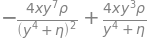

In [14]:
diff(ro*x*(y**4)/(eta + y**4), y)

In [24]:
dfdy_phys = 4*x*(y**3)*(ro*eta/((eta+y**4)**2)-mu)
dgdy_phys = 0.25*(alpha*(1-5*beta*y**4)-x-(b*(1-3*y**4))/((1+y**4)**2))
simplify(dfdy-dfdy_phys),simplify(dgdy-dgdy_phys)
# Производные верные

In [25]:
bless_params[mu] = 0.001
bless_params
params = dict(bless_params)
params[b] = 0.898
eps = 0.1

In [26]:
params

In [27]:
eqs = get_eqs_by_starts(params, starts = itertools.product(np.linspace(1.2, 1.8, 10),
                                                           np.linspace(1.5, 1.8, 10)))
united_eqs = sorted(union_same_solutions(eqs))
(eq_at,) = united_eqs

Finding eq: : 100it [00:03, 26.23it/s]


In [28]:
eq_at

In [29]:
#b1 = 0.899, b2 = 0.982, b3 = 1.332

In [31]:
r = []
for curb in np.linspace(0.7, 1, 10):
    W_f = get_ssm(eq_at, bless_params | {b: curb})
    eig_val1, eig_val2 = sorted([e_val for (e_val, m, _) in W_f.eigenvects()])
    r.append((curb, eig_val1, eig_val2))

evals = pd.DataFrame(r, columns=['b', 'l1', 'l2']).astype(float)

fig = get_white_fig()
fig.update_layout(title=f"")
fig.update_layout(xaxis={"title": r"b"}, yaxis={
    "title":  r"lambda"})
fig.add_trace(go.Scatter(x=evals.b,y=evals.l1))
fig.add_trace(go.Scatter(x=evals.b,y=evals.l2))
# fig.update_yaxes(type="log")

fig.show()


лямбды правильные

In [38]:
params

In [47]:
fig = get_white_fig()
p = 0.99
el = get_ellipse(eq_at, p, eps=0.1, params=params)
fig = fig_add_ellipse(fig, el, name=f'P = {p}')

In [48]:
# el


In [49]:
plot_eq(eq_at, fig, color='green',name='eq_at E1')
fig

Добавим распрделение точек вокруг равновесия

In [50]:
H

In [51]:
paths = get_paths(params, [eq_at]*5, num_steps=1000, h=H)

Finding paths: 100%|██████████| 5/5 [01:35<00:00, 19.18s/it]


In [54]:
eq_at

In [52]:
paths.head(5)

,no,step,x,y,path_id,name,ysqrt4
0,0.0,0.0,1.504840,1.64908,836069.0,to_at,1.13321
1,0.0,1.0,1.504840,1.64908,836069.0,to_at,1.13321
2,0.0,2.0,1.504840,1.64908,836069.0,to_at,1.13321
3,0.0,3.0,1.504840,1.64908,836069.0,to_at,1.13321
4,0.0,4.0,1.504839,1.64908,836069.0,to_at,1.13321


In [53]:
fig.add_trace(go.Scatter(x=paths.x, y=paths.y,
                  mode="markers", name=''))
fig
